In [2]:
from data import train, test
import pandas as pd
import numpy as np
import re

# Preprocessing

In [3]:
train.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
col = ["UserName", "ScreenName", "Location", "TweetAt"]
train.drop(col, axis=1, inplace = True)
test.drop(col, axis=1, inplace = True)

<AxesSubplot:>

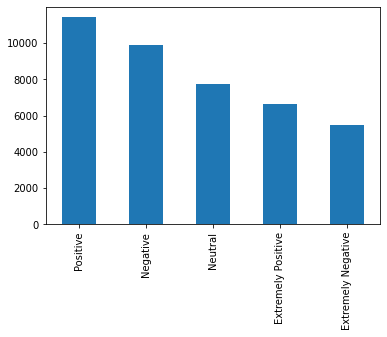

In [5]:
train.Sentiment.value_counts().plot(kind="bar")

<AxesSubplot:>

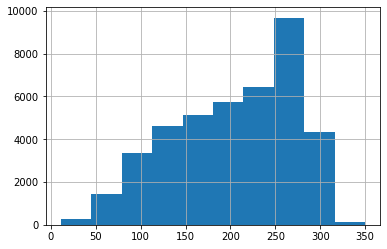

In [6]:
train.OriginalTweet.str.len().hist()

In [7]:
train = train[train.Sentiment != 'Neutral']
test = test[test.Sentiment != 'Neutral']

<AxesSubplot:>

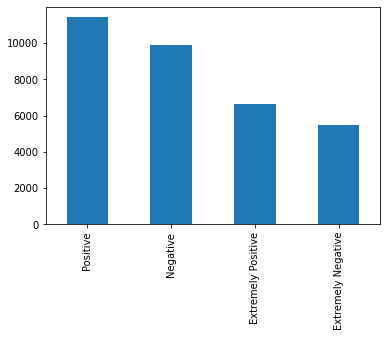

In [8]:
train.Sentiment.value_counts().plot(kind="bar")

In [9]:
def rename(x):
    if x == "Extremely Positive":
        return 'positive'
    elif x == "Extremely Negative":
        return 'negative'
    elif x == "Positive":
        return 'positive'
    else:
        return 'negative'
    
train = train[train.Sentiment != 'Neutral']
test = test[test.Sentiment != 'Neutral']

train['Sentiment'] = train.Sentiment.apply(rename)
test['Sentiment'] = test.Sentiment.apply(rename)

In [10]:
train.Sentiment.value_counts()

positive    18046
negative    15398
Name: Sentiment, dtype: int64

### Lemmitization

In [25]:
# Performing Lemmitization
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

spacy_ = spacy.load("en_core_web_sm")

checker = lambda i: (spacy_.vocab[i.text].is_stop or i.like_email or i.is_punct or i.like_url or i.is_digit or i.is_space)

def lemmatizing(word):
    doc = spacy_(word)
    doc = [i.lemma_ for i in doc if not checker(i)]
    return ' '.join(doc).lower()
    

train['ModifiedTweets'] = train.OriginalTweet.apply(lemmatizing)
test['ModifiedTweets'] = test.OriginalTweet.apply(lemmatizing)

In [26]:
train.to_csv("data/train_procesed.csv", index=False)
test.to_csv("data/test_processed.csv", index=False)

In [35]:
train = pd.read_csv("data/train_procesed.csv")

In [36]:
train.head(4)

,OriginalTweet,Sentiment,ModifiedTweets
0,advice Talk to your neighbours family to excha...,positive,advice talk neighbours family exchange phone n...
1,Coronavirus Australia: Woolworths to give elde...,positive,coronavirus australia woolworth elderly disabl...
2,My food stock is not the only one which is emp...,positive,food stock panic food need stay calm stay safe...
3,"Me, ready to go at supermarket during the #COV...",negative,ready supermarket covid19 outbreak paranoid fo...


In [42]:
train.OriginalTweet[34]

'CHECK VIDEO ?? https://t.co/1ksn9Brl02 ??No food ? in USA market due to coronavirus panic we gonna die from starvation #CoronavirusOutbreak #coronavirus #houston #nofood #Notoiletpaper #NoHandShakes #nohandsanitizer #COVID19 #pandemic #totallockdown #COVID2019usa #walmart https://t.co/ztN3iMkgpD'

In [41]:
train.ModifiedTweets[34]

'check video food usa market coronavirus panic gon na die starvation coronavirusoutbreak coronavirus houston nofood notoiletpaper nohandshake nohandsanitizer covid19 pandemic totallockdown covid2019usa walmart'

## Building ModeL

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, plot_confusion_matrix, plot_precision_recall_curve, plot_det_curve, plot_roc_curve
from sklearn.linear_model import LogisticRegression

In [243]:
vec = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1)

train_docn = vec.fit_transform(train.ModifiedTweets)
test_doc = vec.transform(test.ModifiedTweets)

In [245]:
vec.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.9,
 'max_features': None,
 'min_df': 3,
 'ngram_range': (1, 2),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': 1,
 'stop_words': None,
 'strip_accents': 'unicode',
 'sublinear_tf': 1,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': 1,
 'vocabulary': None}

In [265]:
def get_naive(train_y):
    naive_bayes_classifer = MultinomialNB(alpha = .3)
    naive_bayes_classifer.fit(train_doc, train_y)
    return naive_bayes_classifer

def get_lin(train_y):
    linear = LogisticRegression(C=4, dual=True, solver='liblinear', random_state=42)
    return linear.fit(train_doc, train_y)

In [266]:
train_y = pd.get_dummies(train.Sentiment, drop_first=True).values.reshape(len(train))
test_y = pd.get_dummies(test.Sentiment, drop_first=True).values.reshape(len(test))

In [267]:
model = get_lin(train_y)

In [268]:
predicts = model.predict(test_doc)

In [269]:
accuracy_score(predicts, test_y)

0.8518402013211702

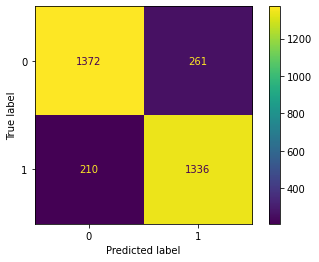

In [270]:
plot_confusion_matrix(model, test_doc, test_y)

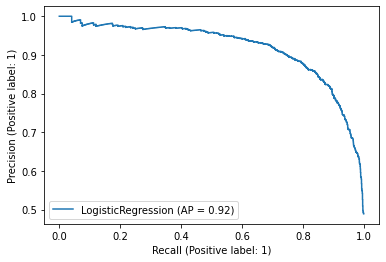

In [271]:
plot_precision_recall_curve(model, test_doc, test_y)

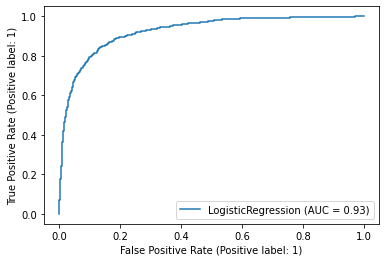

In [272]:
plot_roc_curve(model, test_doc, test_y)

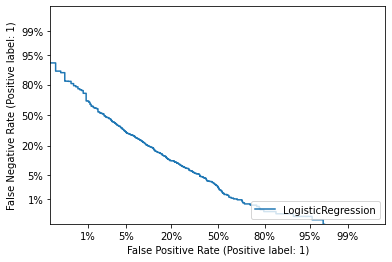

In [273]:
plot_det_curve(model, test_doc, test_y)